In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

In [32]:
df = pd.read_excel("../data/betting_results.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

df

,Match,Date,Market,Market Group,Odds,Market Odds,EV,Result,Bet Amount (%),Profit/Loss (%),Bet Amount,PL Amount,Acc BA,Acc PL,Balance
0,Nice vs Rennes,2025-01-03,home,1X2,2.148,2.351,0.094507,1.0,0.026049,0.035192,260.487524,351.918645,260.487524,351.918645,9739.512476
1,Nice vs Rennes,2025-01-03,under_15,Over/Under,2.712,3.200,0.179941,-1.0,0.030457,-0.030457,296.636911,-296.636911,557.124436,55.281734,9442.875564
2,Nice vs Rennes,2025-01-03,under_25,Over/Under,1.580,1.740,0.101266,-1.0,0.050958,-0.050958,481.189297,-481.189297,1038.313733,-425.907563,8961.686267
3,Nice vs Rennes,2025-01-03,under_35,Over/Under,1.212,1.280,0.056106,-1.0,0.059580,-0.059580,533.937268,-533.937268,1572.251000,-959.844831,8427.749000
4,Nice vs Rennes,2025-01-03,home_0,Asian Handicap,1.500,1.670,0.113333,1.0,0.059580,0.039919,502.125285,336.423941,2074.376286,-623.420890,7925.623714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5096,Fortuna Sittard vs Willem II,2025-04-27,under_15,Over/Under,2.498,3.620,0.449159,1.0,0.059024,0.154642,590.238400,1546.424608,882.253497,1683.543120,127165.915374
5097,Fortuna Sittard vs Willem II,2025-04-27,under_25,Over/Under,1.504,1.890,0.256649,1.0,0.059024,0.052531,590.238400,525.312176,1472.491897,2208.855296,126575.676974
5098,Fortuna Sittard vs Willem II,2025-04-27,under_35,Over/Under,1.176,1.340,0.139456,1.0,0.059024,0.020068,590.238400,200.681056,2062.730297,2409.536352,125985.438574
5099,Fortuna Sittard vs Willem II,2025-04-27,s2_0,Correct Score,7.402,8.040,0.086193,-1.0,0.004517,-0.004517,45.165458,-45.165458,2501.428613,3936.281152,125546.740259


In [33]:
start_row = pd.DataFrame({
    'Date': [df['Date'].iloc[0] - pd.Timedelta(days=1)],
    'Balance': [10000]
})
df_plot = pd.concat([start_row, df[['Date', 'Balance']]]).reset_index(drop=True)

daily_bets = df.groupby('Date').size().reset_index(name='Number_of_Bets')

df_plot = df_plot.merge(daily_bets, on='Date', how='left')

df_plot['Number_of_Bets'] = df_plot['Number_of_Bets'].fillna(0)

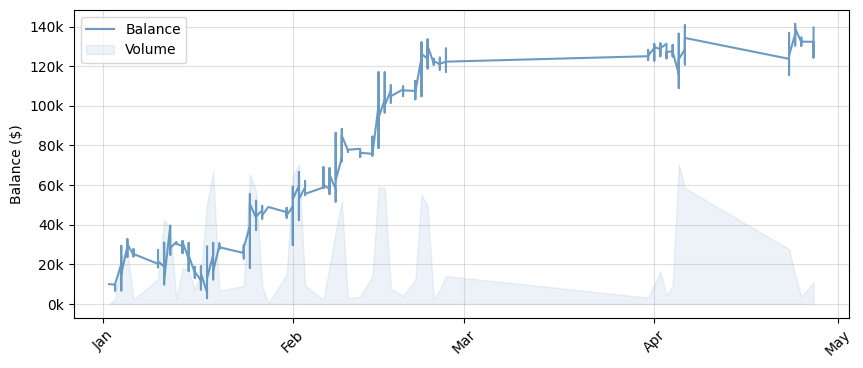

In [34]:
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot balance
ax1.plot(df_plot['Date'], df_plot['Balance'], lw=1.5, color='steelblue', alpha=0.8, label='Balance')
ax1.set_ylabel("Balance ($)")
ax1.grid(True, alpha=0.4)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1000:.0f}k'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

volume_scaled = df_plot['Number_of_Bets'] * df_plot['Balance'].max() / df_plot['Number_of_Bets'].max() * 0.5

ax1.fill_between(df_plot['Date'], 0, volume_scaled, color='steelblue', alpha=0.1, label='Volume')

ax1.legend(loc='upper left')
plt.show()

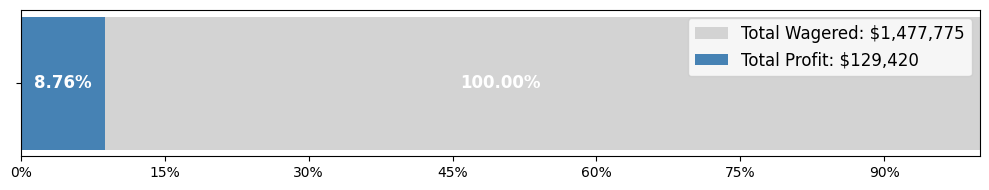

In [35]:
def dollar_to_percent(x, pos):
    return f'{x / total_wagered * 100:.0f}%'

total_profit = df['PL Amount'].sum()
total_wagered = df['Bet Amount'].sum()
roi = (total_profit / total_wagered)

fig, ax = plt.subplots(figsize=(10, 2))

ax.barh([''], [total_wagered], color='lightgray', label=f'Total Wagered: ${total_wagered:,.0f}')
ax.barh([''], [total_profit], color='steelblue', label=f'Total Profit: ${total_profit:,.0f}')

ax.set_xlim(0, total_wagered)
percent_ticks = np.arange(0, 101, 15)   
tick_positions = (percent_ticks / 100) * total_wagered
ax.set_xticks(tick_positions)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(dollar_to_percent))

ax.text(total_profit / 2, 0, f'{roi:.2%}', ha='center', va='center',
        color='white', fontweight='bold', fontsize=12)
ax.text(total_wagered / 2, 0, f'{1:.2%}', ha='center', va='center',
        color='white', fontweight='bold', fontsize=12)

ax.legend(loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()

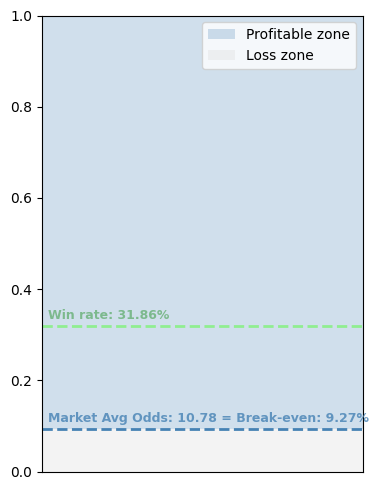

In [36]:
win_rate = (df['PL Amount'] > 0).mean()
avg_odds = df['Market Odds'].mean() 
breakeven = 1 / avg_odds

fig, ax = plt.subplots(figsize=(4,5))

ax.axhspan(breakeven, 1, facecolor='steelblue', alpha=0.25, label='Profitable zone')
ax.axhspan(0, breakeven, facecolor='lightgray', alpha=0.25, label='Loss zone')

ax.axhline(y=breakeven, color='steelblue', linestyle='--', linewidth=2)

ax.axhline(y=win_rate, color='lightgreen', linestyle='--', linewidth=2)

ax.text(0.02, breakeven + 0.01, f'Market Avg Odds: {avg_odds:.2f} = Break-even: {breakeven:.2%}',
        transform=ax.get_yaxis_transform(), color='steelblue', alpha=0.8, fontweight='semibold', fontsize=9,
        verticalalignment='bottom')
ax.text(0.02, win_rate + 0.01, f'Win rate: {win_rate:.2%}',
        transform=ax.get_yaxis_transform(), color='green', alpha=0.4, fontweight='semibold', fontsize=9,
        verticalalignment='bottom')

ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

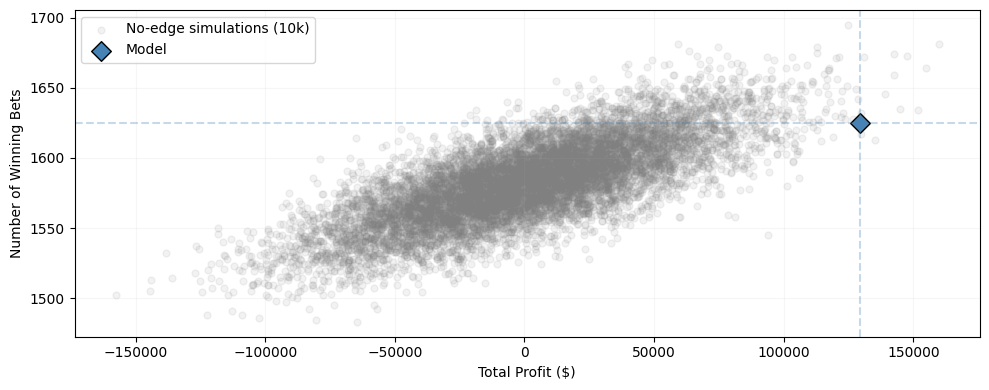

In [37]:
profits = df['PL Amount'].values
actual_total = profits.sum()
actual_wins = (profits > 0).sum()

odds = df['Market Odds'].values
stake = df['Bet Amount'].values
p_win = 1 / odds

n_sim = 10000

rand = np.random.random((n_sim, len(profits)))
wins = rand < p_win

profit_if_win = (odds - 1) * stake
profit_if_loss = -stake
sim_profits = wins * profit_if_win + (~wins) * profit_if_loss

sim_totals = sim_profits.sum(axis=1)
sim_wins = wins.sum(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))

ax.scatter(sim_totals, sim_wins, alpha=0.1, s=25, color='gray', label='No-edge simulations (10k)')
ax.scatter(actual_total, actual_wins, color='steelblue', s=100, marker='D', edgecolors='black', label=f'Model')

ax.axhline(y=actual_wins, color='steelblue', linestyle='--', alpha=0.3)
ax.axvline(x=actual_total, color='steelblue', linestyle='--', alpha=0.3)

ax.set_xlabel('Total Profit ($)')
ax.set_ylabel('Number of Winning Bets')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.1)

plt.tight_layout()
plt.show()

In [38]:
p_value_sim = (sim_totals >= actual_total).mean()
bet_returns = df['Balance'].pct_change().dropna()
sharpe_ratio_bet = bet_returns.mean() / bet_returns.std()
total_bets = 5101

sharpe_ratio = sharpe_ratio_bet * np.sqrt(total_bets)

print(f"Sharpe Ratio per bet: {sharpe_ratio_bet:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Simulation-based p-value: {p_value_sim:.4f}")

Sharpe Ratio per bet: 0.05
Sharpe Ratio: 3.48
Simulation-based p-value: 0.0012


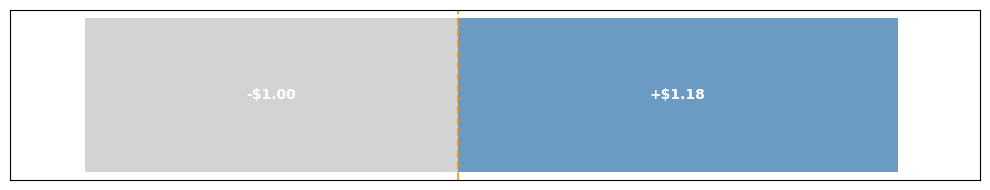

In [39]:
loss = 1.0
win = 1.18

fig, ax = plt.subplots(figsize=(10, 2))

ax.barh(y=0, width=loss, left=-loss, color='lightgray', linewidth=1)
ax.barh(y=0, width=win, left=0, color='steelblue', alpha=0.8, linewidth=1)

ax.axvline(x=0, color='darkorange', linestyle='--', linewidth=1.5, alpha=0.8)

ax.set_xlim(-1.2, 1.4)
ax.set_yticks([])
ax.set_xticks([])

# Loss
ax.text(-loss/2, 0, f'-${loss:.2f}', ha='center', va='center', color='white', fontweight='bold')
# Recoup
ax.text(win/2, 0, f'+${win:.2f}', ha='center', va='center', color='white', fontweight='bold')


plt.tight_layout()
plt.show()

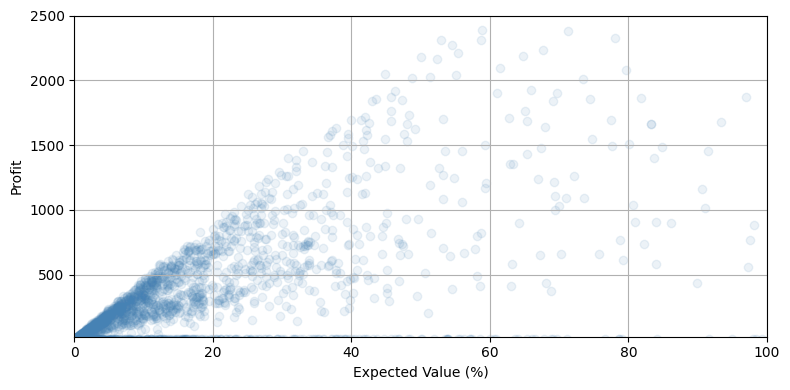

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(df['EV'] * 100, df['PL Amount'], color='steelblue', alpha=0.1)
plt.xlim(0, 100)
plt.ylim(20, 2500)
plt.xlabel("Expected Value (%)")
plt.ylabel("Profit")
plt.grid(True)

fig.tight_layout()
plt.show()


In [41]:
df['Market Odds'] = pd.to_numeric(df['Market Odds'], errors='coerce')
df['Odds'] = pd.to_numeric(df['Odds'], errors='coerce')
df['EV'] = pd.to_numeric(df['EV'], errors='coerce')
df['Result'] = pd.to_numeric(df['Result'], errors='coerce')
df['Bet Amount'] = pd.to_numeric(df['Bet Amount'], errors='coerce')
df['PL Amount'] = pd.to_numeric(df['PL Amount'], errors='coerce')

column_order = ['Match', 'Date', 'Market Group', 'Odds', 'Market Odds', 'EV', 
                'Result', 'Bet Amount', 'PL Amount']
df = df[column_order]

# Calculate statistics by market
print(f"\n--- Statistics by Market Type ---")

# Group by market and calculate statistics
market_stats = df.groupby('Market Group').agg({
    'Market Odds': 'mean',
    'Result': ['count', lambda x: (x > 0).sum(), lambda x: (x < 0).sum()],
    'PL Amount': 'sum',
    'Bet Amount': 'mean'
}).round(2)

market_stats.columns = ['Avg Market Odds', 'Total Bets', 'Winning Bets', 'Losing Bets', 'Total P/L', 'Avg Bet Amount']
market_stats['Win Rate (%)'] = (market_stats['Winning Bets'] / market_stats['Total Bets'] * 100).round(2)

winning_bets_stats = df[df['Result'] > 0].groupby('Market Group')['Market Odds'].mean().round(2)
winning_bets_stats = winning_bets_stats.fillna(0)

market_stats = market_stats[['Total Bets', 'Winning Bets', 'Losing Bets', 'Win Rate (%)', 
                            'Total P/L', 'Avg Bet Amount', 'Avg Market Odds']]

print(market_stats)


--- Statistics by Market Type ---
                Total Bets  Winning Bets  Losing Bets  Win Rate (%)  \
Market Group                                                          
1X2                    648           184          464         28.40   
Asian Handicap        1798           732          814         40.71   
Correct Score         1477            93         1384          6.30   
Over/Under            1178           616          562         52.29   

                Total P/L  Avg Bet Amount  Avg Market Odds  
Market Group                                                
1X2              19785.89          283.28             4.71  
Asian Handicap   68291.19          392.68             3.33  
Correct Score    -6109.74           68.29            29.08  
Over/Under       47452.58          413.68             2.57  


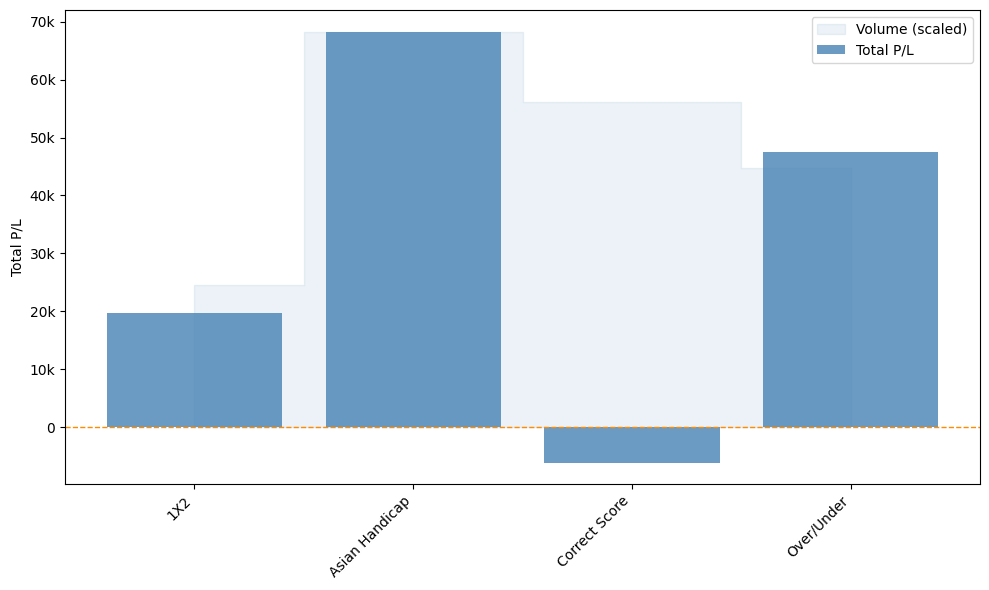

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

max_pl = market_stats['Total P/L'].max()
max_bets = market_stats['Total Bets'].max()
scaling_factor = max_pl / max_bets if max_bets != 0 else 1
volume_scaled = market_stats['Total Bets'] * scaling_factor

x_pos = range(len(market_stats.index))

ax.fill_between(x_pos, volume_scaled, 
                color='steelblue', alpha=0.1, step='mid',
                label='Volume (scaled)')

ax.bar(x_pos, market_stats['Total P/L'], 
       color='steelblue', alpha=0.8, label='Total P/L')

ax.axhline(y=0, color='darkorange', linewidth=1, linestyle='--')

def thousands_formatter(x, pos):
    return f'{int(x/1000)}k' if x != 0 else '0'
ax.yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

ax.set_xticks(x_pos)
ax.set_xticklabels(market_stats.index, rotation=45, ha='right')

ax.set_ylabel('Total P/L')
ax.legend()

fig.tight_layout()
plt.show()